# SGD Implementation from scratch - with SGD Momentum and SGD Adagrad

1. (5pts) Using stochastic gradient descent, derive the coefficent updates for all 5 coefficients of the model: $$ y = w_0 + w_1x_1 + w_2x_1x_2 + w_3x_1^2x_2^2 + w_4x_2^3$$ Hint: start from the cost function (Assume sum of squared error). If you write the math by hand, include the image in your notebook and upload the image in the submission.


2. (20pts) Write Python code for an SGD solution to the non-linear model$$ y = w_0 + w_1x_1 + w_2x_1x_2 + w_3x_1^2x_2^2 + w_4x_2^3$$ Try to format similarly to scikit-learn's models. The template of the class is given. The init function of the class takes as input the learning_rate, regularization_constant and number of epochs. The fit method must take as input X,y and a choice of update_rule as 'sgd' or 'sgd_momentum' or 'Adagrad'. The _predict_ method takes an X value (optionally, an array of values). Use your new gradient descent regression to predict the data given in 'samples.csv', for 15 epochs, using learning rates: [0, .0001, .001, .01, 0.1, 1, 10, 100] and regularization (ridge regression) constants: [0,10,100] . Plot MSE and the $w$ parameters as a function of epoch (for 15 epochs) for the best 2 combinations of learning_rate and regularization for SGD, SGD-Momentum and Adagrad. I.e., you should have one plot of MSE and another for the parameter updates for SGD, SGD-Momentum and Adagrad (6 plots total). (2pts) Report the MSE at the end of 15 epochs for the two best combinations in each of SGD, SGD-Momentum and Adagrad.

Here are two blogs which you can go through to know about Adagrad - [blog 1](https://medium.com/konvergen/an-introduction-to-adagrad-f130ae871827) and [blog 2](http://ruder.io/optimizing-gradient-descent/).


3. (5pts) Based on the experiments, which of the 3 techniques allowed for a larger initial setting of the learning_rate? Why?


In [2]:
%matplotlib inline
import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import warnings

class LinearRegression:
    
    def __init__(self, learning_rate, regularization, n_epoch):
        self.learning_rate = learning_rate
        self.n_epoch = n_epoch
        self.regularization = regularization
        self.coef = np.zeros(5) #one coef for each of the terms
        self.eps = 10**-6 #used only for adagrad
        self.cache = np.zeros(self.coef.shape) #used only for adagrad
        self.mu = 0.9 #used in momentum
        self.velocity = 0


        
    def sgd(self,eta,gradient):
        '''
        updates self.coef based on gradient using SGD
        update rule to come here...
        '''
        self.coef = self.coef - eta*gradient
        return self.coef
    
    def adagrad(self,eta,gradient,gradient_matrix):
        grad_sq = np.power(gradient_matrix,2).sum()
        grad_ada = eta/np.sqrt(self.eps+grad_sq)
        grad_ada_d = np.diag(grad_ada, k=0)
        grad_upd = grad_ada_d.dot(gradient)
        self.coef = self.coef - grad_upd
        return self.coef
        '''
        updates self.coef based on gradient using Adagrad
        '''
        
    
    def sgd_momentum(self,eta,gradient):
        self.velocity = (self.velocity*self.mu)+((1-self.mu)*gradient)
        self.coef = self.coef - eta*self.velocity
        return self.coef
        '''
        updates self.coef based on gradient using Sgd_momentum
        '''
    
        
    def fit(self, X, y, update_rule='sgd', plot=False):
        '''
        Fits the model for the given X, y. It uses the update rule mentioned by the parameter update_rule
        and displays a plot of the coefficients vs epochs and mse vs epochs if plot is True. 
        
        -> use get_features to get the features from X
        -> for epoch in epochs:
            iterate through all x, y.
                compute prediction using linearPredict.
                compute gradient.
                pass this gradient to the respective update rule and update the coefficients
                keep track of mse and coefficients
        -> plot if required
        
        '''
        
        X_features = self.get_features(X)
        n = X_features.shape[0] 
        j = X_features.shape[1] 
        epoch_summary = pd.DataFrame(columns=['learning_rate','lambda_reg','n_epoch','Intercept','w1','w2','w3','w4','MSE'])
        
        for eta in self.learning_rate:
            self.coef = np.zeros(5)
            self.velocity = 0
            for lambda_reg in self.regularization:
                for epoch in range(self.n_epoch): 
                    grad_mat = pd.DataFrame(columns=['gIntercept','gw1','gw2','gw3','gw4'])
                    for i in range(n):#n-1
                        y_pred =  self.linearPredict(X_features[i])
                        residuals = y[i] - y_pred
                        _grad = residuals*(X_features[i])
                        reg_grad = 2 * lambda_reg * self.coef
                        reg_grad[0] = 0 # -- since bias term is not counted in l2 regularization
                        grad =  reg_grad - _grad
                        grad_mat = grad_mat.append({'gIntercept':grad[0],'gw1':grad[1],'gw2':grad[2],
                                                    'gw3':grad[3],'gw4':grad[4]},ignore_index=True)
                        if update_rule == 'sgd':
                            self.coef = self.sgd(eta,grad)
                        elif update_rule == 'adagrad':
                            self.coef = self.adagrad(eta,grad,grad_mat)
                        elif update_rule == 'momentum':
                            self.coef = self.sgd_momentum(eta,grad)
                        else: 
                            return (print('invalid update rule'))
                            
                            
                    y_pred_epoch = self.linearPredict(X_features)
                    res_epoch = y - y_pred_epoch
                    SE = np.power(res_epoch,2)
                    MSE = np.mean(SE)
                    epoch_summary = epoch_summary.append({'learning_rate':eta,'lambda_reg':lambda_reg,
                                                          'n_epoch':epoch,'Intercept':self.coef[0],
                                                          'w1':self.coef[1], 'w2':self.coef[2],
                                                          'w3':self.coef[3], 'w4':self.coef[4],'MSE':MSE}, ignore_index=True)
#                     print ('--------------------epoch ends----------------')
        model_summary = epoch_summary.groupby(['learning_rate','lambda_reg'])[['MSE']].mean()
        model_summary.reset_index(inplace=True)
        model_summary['model_rank'] = model_summary['MSE'].rank(method='dense',ascending=True)
        model_summary = model_summary.sort_values(['model_rank'])
        print ('--## Avg MSE across 15 epochs for different combination of learning rate and regularization ##--')
        print (model_summary)
        model_summary = model_summary[model_summary['model_rank']<=2] #--update rank here
        print ('------Best 2 combination of learning rate and regularization-------')
        print (model_summary)
        best_lr1 = model_summary[model_summary['model_rank']==1]['learning_rate']
        best_lr2 = model_summary[model_summary['model_rank']==2]['learning_rate']
        best_lambda1 = model_summary[model_summary['model_rank']==1]['lambda_reg']
        best_lambda2 = model_summary[model_summary['model_rank']==2]['lambda_reg']
        #----filter for best epochs based on MSE values
        epoch_summary1 = epoch_summary[(epoch_summary['learning_rate'].isin(best_lr1))&(epoch_summary['lambda_reg'].isin(best_lambda1))]
        epoch_summary2 = epoch_summary[(epoch_summary['learning_rate'].isin(best_lr2))&(epoch_summary['lambda_reg'].isin(best_lambda2))]
#         print (epoch_summary1)
        #----generating plots
        if plot==True:
            fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))
            title = 'Model weights and MSE progression by epoch, method:'+update_rule
            fig.suptitle(title)
            ax[0,0].plot(epoch_summary1['n_epoch'], epoch_summary1['Intercept'],label='w0')
            ax[0,0].plot(epoch_summary1['n_epoch'], epoch_summary1['w1'],label='w1')
            ax[0,0].plot(epoch_summary1['n_epoch'], epoch_summary1['w2'],label='w2')
            ax[0,0].plot(epoch_summary1['n_epoch'], epoch_summary1['w3'],label='w3')
            ax[0,0].plot(epoch_summary1['n_epoch'], epoch_summary1['w4'],label='w4')
            ax[0,0].set(xlabel='# epoch',ylabel='weights')
            ax[0,0].legend(loc="upper right")

            ax[0,1].plot(epoch_summary2['n_epoch'], epoch_summary2[['MSE']],label='MSE')
            ax[0,1].set(xlabel='# epoch',ylabel='MSE')
            ax[0,1].legend(loc="upper right")
            
            ax[1,0].plot(epoch_summary2['n_epoch'], epoch_summary2['Intercept'],label='w0')
            ax[1,0].plot(epoch_summary2['n_epoch'], epoch_summary2['w1'],label='w1')
            ax[1,0].plot(epoch_summary2['n_epoch'], epoch_summary2['w2'],label='w2')
            ax[1,0].plot(epoch_summary2['n_epoch'], epoch_summary2['w3'],label='w3')
            ax[1,0].plot(epoch_summary2['n_epoch'], epoch_summary2['w4'],label='w4')
            ax[1,0].set(xlabel='# epoch',ylabel='weights')
            ax[1,0].legend(loc="upper right")

            ax[1,1].plot(epoch_summary2['n_epoch'], epoch_summary2[['MSE']],label='MSE')
            ax[1,1].set(xlabel='# epoch',ylabel='MSE')
            ax[1,1].legend(loc="upper right")
 
            

    def get_features(self, X):
        a = np.array(X)
        a1 = np.ones((a.shape[0], 1), dtype=a.dtype)
        a3 = np.multiply(a[:,0],a[:,1])
        a3.shape = (len(a3),1)
        a4 = np.multiply(np.power(a[:,0],2),np.power(a[:,1],2))
        a4.shape = (len(a4),1)
        a5 = np.power(a[:,1],3)
        a5.shape = (len(a5),1)

        a = np.hstack((a1, a))
        a = np.hstack((a,a3))
        a = np.hstack((a,a4))
        a = np.hstack((a,a5))
        X = np.delete(a, 2, axis=1)
        return X

        
    def linearPredict(self, X_features):
        return X_features.dot(self.coef)
       

In [3]:
data = pd.read_csv('q1_samples.csv')
X = np.array([data['x1'].values, data['x2'].values]).T
y = data['y'].values
n_epochs = 15
learning_rate = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100] 
regularization = [0, 10, 100]

from sklearn.preprocessing import scale
# --scaling X and Y 
X = scale(X, axis=0, with_mean=True, with_std=True)
y = scale(y, axis=0, with_mean=True, with_std=True)

## Using SGD

--## Avg MSE across 15 epochs for different combination of learning rate and regularization ##--
    learning_rate  lambda_reg            MSE  model_rank
6         0.00100         0.0   6.722955e-01         1.0
9         0.01000         0.0   6.955934e-01         2.0
3         0.00010         0.0   7.275710e-01         3.0
1         0.00001        10.0   8.882411e-01         4.0
4         0.00010        10.0   8.994678e-01         5.0
0         0.00001         0.0   9.210626e-01         6.0
7         0.00100        10.0   9.274533e-01         7.0
2         0.00001       100.0   9.852753e-01         8.0
5         0.00010       100.0   9.910767e-01         9.0
10        0.01000        10.0   9.913287e-01        10.0
8         0.00100       100.0   9.984935e-01        11.0
12        0.10000         0.0   7.892859e+02        12.0
11        0.01000       100.0  8.799484e+228        13.0
13        0.10000        10.0            inf        14.0
15        1.00000         0.0            inf    

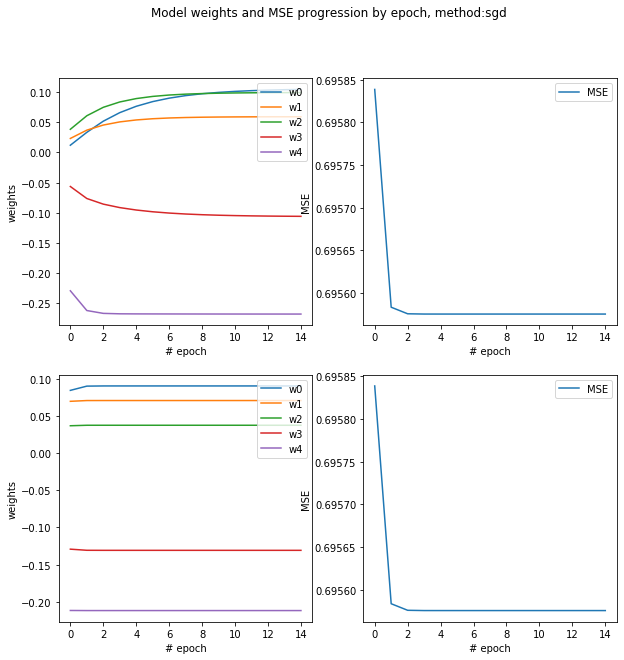

In [4]:
warnings.filterwarnings("ignore")

model = LinearRegression(learning_rate, regularization, n_epochs)
model.fit(X, y, update_rule='sgd', plot=True)

### Using SGD-Momentum

--## Avg MSE across 15 epochs for different combination of learning rate and regularization ##--
    learning_rate  lambda_reg           MSE  model_rank
6         0.00100         0.0  6.720574e-01         1.0
9         0.01000         0.0  7.216109e-01         2.0
3         0.00010         0.0  7.274413e-01         3.0
1         0.00001        10.0  8.881282e-01         4.0
4         0.00010        10.0  8.988279e-01         5.0
0         0.00001         0.0  9.211056e-01         6.0
7         0.00100        10.0  9.225936e-01         7.0
10        0.01000        10.0  9.265603e-01         8.0
2         0.00001       100.0  9.852094e-01         9.0
5         0.00010       100.0  9.903754e-01        10.0
8         0.00100       100.0  9.912456e-01        11.0
11        0.01000       100.0  1.025094e+00        12.0
14        0.10000       100.0  1.071834e+00        13.0
13        0.10000        10.0  2.073242e+39        14.0
12        0.10000         0.0  5.414460e+57        15.0
15     

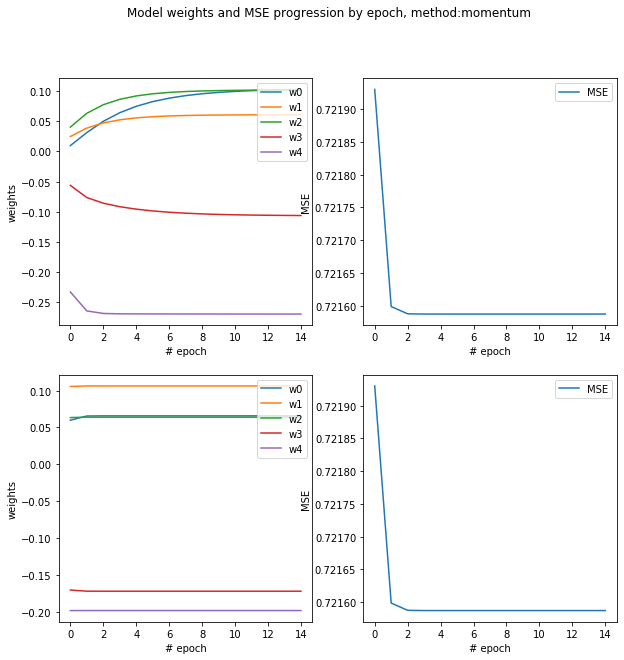

In [5]:
warnings.filterwarnings("ignore")

model = LinearRegression(learning_rate, regularization, n_epochs)
model.fit(X, y, update_rule='momentum', plot=True)

### Using Adagrad

--## Avg MSE across 15 epochs for different combination of learning rate and regularization ##--
    learning_rate  lambda_reg       MSE  model_rank
12        0.10000         0.0  0.674126         1.0
9         0.01000         0.0  0.677736         2.0
15        1.00000         0.0  0.757970         3.0
6         0.00100         0.0  0.795520         4.0
7         0.00100        10.0  0.873941         5.0
10        0.01000        10.0  0.912874         6.0
4         0.00010        10.0  0.930601         7.0
13        0.10000        10.0  0.937615         8.0
3         0.00010         0.0  0.967177         9.0
5         0.00010       100.0  0.971149        10.0
2         0.00001       100.0  0.988045        11.0
8         0.00100       100.0  0.988923        12.0
1         0.00001        10.0  0.990420        13.0
11        0.01000       100.0  0.993072        14.0
0         0.00001         0.0  0.996572        15.0
14        0.10000       100.0  1.001220        16.0
17        1.00000  

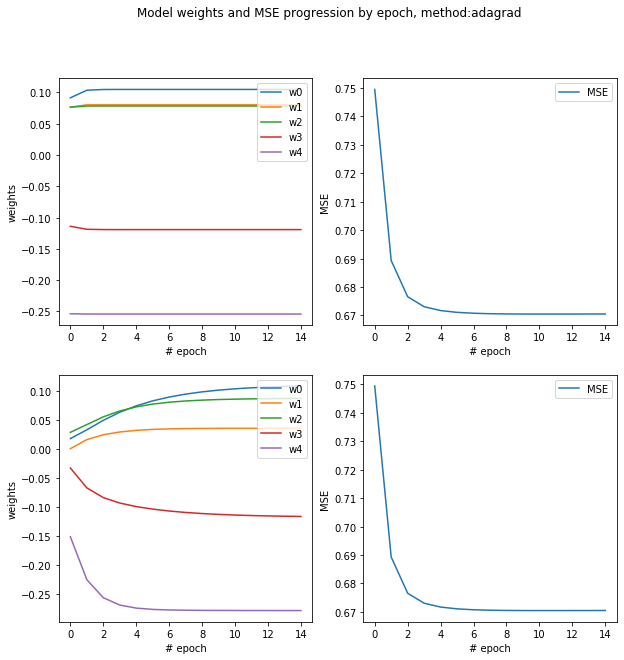

In [4]:
warnings.filterwarnings("ignore")

model = LinearRegression(learning_rate, regularization, n_epochs)
model.fit(X, y, update_rule='adagrad', plot=True)